<a href="https://colab.research.google.com/github/ricardoV94/ThinkBayesPymc3/blob/master/ThinkBayes_Chapter_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
pip install arviz

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

## 8.1 The Red Line problem

In [0]:
# found on https://github.com/AllenDowney/ThinkBayes/blob/802f5c0b84a01a0c7fd1ca0ac66c2ae0dcd1b1e1/code/redline.py#L38 
OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]
OBSERVED_GAP_TIMES = np.array(OBSERVED_GAP_TIMES)/60

In [0]:
def estimate_pdf(samples, _min=None, _max=None):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin

    x = np.linspace(smin, smax, 100)
    y = st.gaussian_kde(samples)(x)

    # Extend beyond samples range
    if _min is None:
        _min = smin - 3 * width
    if _max is None:
        _max = smax + 3 * width
    x = np.concatenate([[_min], x, [_max]])
    y = np.concatenate([[0], y, [0]])
    
    return x, y

gap_values, gap_pdfs = estimate_pdf(OBSERVED_GAP_TIMES, 0, 20)

In [5]:
with pm.Model() as m_8_2:

    # Time between trains
    z = pm.Interpolated('z', gap_values, gap_pdfs)

    # Experienced time between trains
    zb = pm.Interpolated('zb', gap_values, gap_pdfs)
    pm.Potential('bias', pm.math.log(zb))

    trace_m_8_2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zb, z]
100%|██████████| 2500/2500 [00:02<00:00, 906.85it/s]


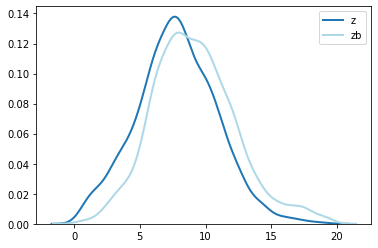

In [6]:
sns.kdeplot(trace_m_8_2['z'], lw=2, label='z')
sns.kdeplot(trace_m_8_2['zb'], lw=2, label='zb', color='lightblue')

## 8.3 Wait Times

In [7]:
with pm.Model() as m_8_3:

    # Time between trains
    z = pm.Interpolated('z', gap_values, gap_pdfs)

    # Experienced time between trains
    zb = pm.Interpolated('zb', gap_values, gap_pdfs)
    pm.Potential('bias', pm.math.log(zb))

    # Time between prev train and passenger arrival
    x = pm.Uniform('x', lower=0, upper=zb)  
    # Time between passenger arrival and next train
    y = pm.Deterministic('y', zb - x)       

    trace_m_8_3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, zb, z]
100%|██████████| 2500/2500 [00:03<00:00, 721.80it/s]


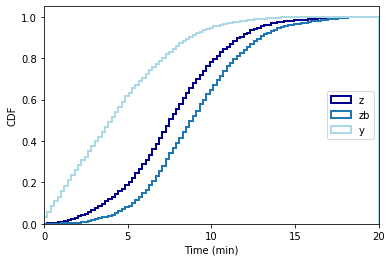

In [8]:
bins = np.linspace(0,20,100)
plt.hist(trace_m_8_3['z'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, color='darkblue', label='z')
plt.hist(trace_m_8_3['zb'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, label='zb')
plt.hist(trace_m_8_3['y'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, color='lightblue', label='y')

plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.xlim([0,20])
plt.xticks(np.linspace(0,20,5))
plt.legend(loc=5);

In [9]:
np.mean(trace_m_8_3['z']), np.mean(trace_m_8_3['zb']), np.mean(trace_m_8_3['y'])

(7.7960817628179155, 9.114821032567878, 4.523772003355625)

## 7.4 Predicting wait times

In [10]:
with pm.Model() as m_8_4:

    # Time between trains
    z = pm.Interpolated('z', gap_values, gap_pdfs)

    # Experienced time between trains
    zb = pm.Interpolated('zb', gap_values, gap_pdfs)
    pm.Potential('bias', pm.math.log(zb))

    # Time between prev train and passenger arrival
    x = pm.Uniform('x', lower=0, upper=zb)  
    # Time between passenger arrival and next train
    y = pm.Deterministic('y', zb - x)  

    # Likelihood of observing n passengers
    lam = 2 # Rate of passenger arrival per minute
    like = pm.Poisson('like', mu=lam*x, observed=15)

    trace_m_8_4 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, zb, z]
100%|██████████| 2500/2500 [00:03<00:00, 626.74it/s]


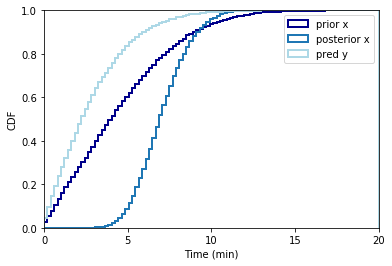

In [11]:
bins = np.linspace(0,20,100)
plt.hist(trace_m_8_3['x'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, color='darkblue', label='prior x')
plt.hist(trace_m_8_4['x'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, label='posterior x')
plt.hist(trace_m_8_4['y'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, color='lightblue', label='pred y')
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.xlim([0,20])
plt.ylim([0,1])
plt.xticks(np.linspace(0,20,5))
plt.legend(loc=1);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e7087e4e0>],
      dtype=object)

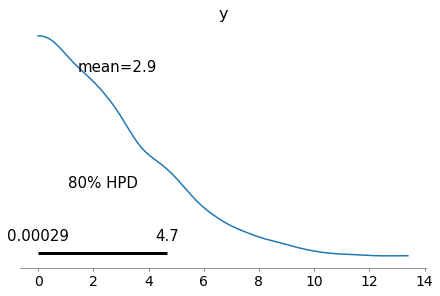

In [12]:
az.plot_posterior(trace_m_8_4, var_names=['y'], credible_interval=.80)

## 8.5 Estimating the arrival rate

In [0]:
data = [[17, 4.6, 9],
        [22, 1, 0],
        [23, 1.4, 4],
        [18, 5.4, 12],
        [4, 5.8, 11]]
data = np.array(data)
y = data[:, 1]
k2 = data[:, 2]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam]
100%|██████████| 2500/2500 [00:01<00:00, 1897.33it/s]


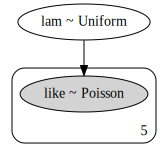

In [14]:
with pm.Model() as m_8_5:
    lam = pm.Uniform('lam', lower=0, upper=5) # Rate of arrival
    like = pm.Poisson('like', lam*y, observed=k2)

    trace_m_8_5_prior = pm.sample_prior_predictive(2000)
    trace_m_8_5 = pm.sample(2000)
pm.model_to_graphviz(m_8_5)

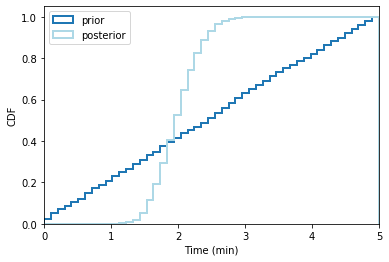

In [15]:
bins = np.linspace(0,5,50)
plt.hist(trace_m_8_5_prior['lam'], cumulative=True, density=True, histtype='step', bins=bins, lw=2, label='prior',)
plt.hist(trace_m_8_5['lam'], cumulative=True, density=True, histtype='step', bins=bins, lw=2, label='posterior', color='lightblue')

plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.xlim([0,5])
plt.xticks(np.linspace(0,5,6))
plt.legend(loc=2);

In [16]:
np.mean(trace_m_8_5['lam']), np.median(trace_m_8_5['lam']), np.std(trace_m_8_5['lam'])

(2.0343069058740944, 2.02113300805037, 0.3317197199743908)

## 8.6 Incorporating uncertainty

In [17]:
with pm.Model() as m_8_6:

    # Time between trains
    z = pm.Interpolated('z', gap_values, gap_pdfs)

    # Experienced time between trains
    zb = pm.Interpolated('zb', gap_values, gap_pdfs)
    pm.Potential('bias', pm.math.log(zb))

    # Time between prev train and passenger arrival
    x = pm.Uniform('x', lower=0, upper=zb)  
    # Time between passenger arrival and next train
    y = pm.Deterministic('y', zb - x)  

    # Likelihood of observing n passengers
    lam = pm.Interpolated('lam', *estimate_pdf(trace_m_8_5['lam'], _min=0))
    like = pm.Poisson('like', mu=lam*x, observed=15)

    trace_m_8_6 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, x, zb, z]
100%|██████████| 2500/2500 [00:05<00:00, 465.46it/s]
The number of effective samples is smaller than 25% for some parameters.


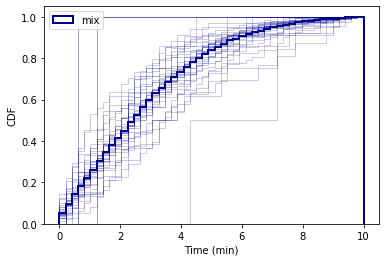

In [18]:
bins = np.linspace(0,10,50)
plt.hist(trace_m_8_6['y'], bins=bins, cumulative=True, density=True, histtype='step', lw=2, color='darkblue', label='mix')
step = .05
for lam in np.arange(1, 3.1, step):
    lam_l = lam - step/2
    lam_h = lam + step/2
    trials = np.where((trace_m_8_6['lam'] > lam_l) & (trace_m_8_6['lam'] <= lam_h))
    plt.hist(trace_m_8_6['y'][trials], bins=bins, cumulative=True, density=True, histtype='step', color='darkblue', alpha=.2)


plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.xticks(np.linspace(0,10,6))
plt.legend(loc=2);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e5d921f60>],
      dtype=object)

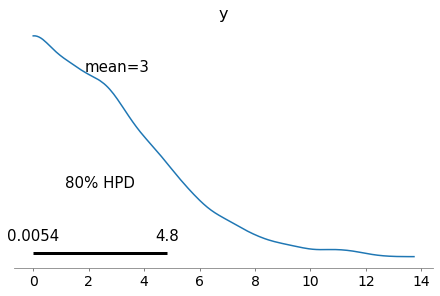

In [19]:
az.plot_posterior(trace_m_8_6, var_names=['y'], credible_interval=.80)

## 8.7 Decision analysis

Data missing...